# Pre-conditioning

Inputs:
1. `model`: Trained rf-time-gan model
2. `given_metadata`: Conditions with metadata values that sessions should have (e.g., all sessions should have `gender = "M"`)

Output:
1. `dataset`: Synthetic dataset with sessions whose metadata fields match the values in `given_metadata`

### Install and Import Rockfish SDK

In [ ]:
%%capture
!pip install -U 'rockfish[labs]==0.22.0.dev6' -f 'https://docs142.rockfish.ai/packages/index.html'  # use rockfish dev release

In [ ]:
import rockfish as rf
import rockfish.actions as ra
import rockfish.labs as rl
import pandas as pd

### Connect to the Rockfish Platform

In [ ]:
api_key = ""  # API key for environment
api_url = ""  # URL for environment
conn = rf.Connection.remote(api_url, api_key)

### Train Rf-Time-GAN on the Finance Dataset

In [ ]:
!wget --no-clobber https://docs142.rockfish.ai/tutorials/finance.csv
dataset = rf.Dataset.from_csv("finance", "finance.csv")

In [ ]:
def get_config(epochs=1,
               sample_len=2,
               sessions=100,
               batch_size=512,
               given_metadata=None):
    timestamp = "timestamp"
    session = "customer"
    metadata_cols = ["age", "gender"]
    con_measurement_cols = ["amount"]
    cat_measurement_cols = ["merchant", "category", "fraud"]
    config = ra.TrainTimeGAN.Config(
        encoder=ra.TrainTimeGAN.DatasetConfig(
            timestamp=ra.TrainTimeGAN.TimestampConfig(field=timestamp),
            metadata=[
                ra.TrainTimeGAN.FieldConfig(field=col, type="categorical")
                for col in metadata_cols
            ] + [
                ra.TrainTimeGAN.FieldConfig(field=session, type="session")
            ],
            measurements=[
                 ra.TrainTimeGAN.FieldConfig(field=col, type="continuous")
                 for col in con_measurement_cols
            ] + [
                 ra.TrainTimeGAN.FieldConfig(field=col, type="categorical")
                 for col in cat_measurement_cols
            ]
        ),
        doppelganger=ra.TrainTimeGAN.DGConfig(
            epoch=epochs,
            epoch_checkpoint_freq=epochs,
            sample_len=sample_len,
            sessions=sessions,
            batch_size=batch_size,
            given_metadata=given_metadata
        )
    )
    return config

In [ ]:
train_config = get_config()  # pass appropriate args for setting hyperparams
train = ra.TrainTimeGAN(train_config)

builder = rf.WorkflowBuilder()
builder.add_path(dataset, train)
workflow = await builder.start(conn)
print(f"Train Workflow: {workflow.id()}")

Train Workflow: 7ptOndmjmcrZo75lur3ABZ


In [ ]:
async for log in workflow.logs(level=rf.events.LogLevel.DEBUG):
    print(log)

2024-08-20T15:48:54Z dataset-load: INFO Loading dataset '2870FgXmZXbWC6TxV5XVUz' with 50000 rows
2024-08-20T15:48:54Z train-time-gan: DEBUG CUDA available
2024-08-20T15:48:54Z train-time-gan: DEBUG Training on cuda:Tesla T4 with cuda version 11.8
2024-08-20T15:49:04Z train-time-gan: INFO Starting DG training job
2024-08-20T15:49:05Z train-time-gan: DEBUG Epoch 1, g_loss_d: -0.7153, g_loss: -0.3460, d_loss_fake:  0.7028, d_loss_real: -10.0695, d_loss_gp:  0.1775, d_loss: -7.5919, g_loss_attr_d:  0.3693, attr_d_loss_fake: -0.3610, attr_d_loss_real: -0.8119, attr_d_loss_gp:  0.0165, attr_d_loss: -1.0081
2024-08-20T15:49:05Z train-time-gan: INFO Epoch 1 completed.
2024-08-20T15:49:05Z train-time-gan: DEBUG Checkpoint on Epoch 1 has been saved to epoch-1.pt
2024-08-20T15:49:11Z train-time-gan: DEBUG Uploaded model bd979f85-5f0b-11ef-9299-42726b435dd2
2024-08-20T15:49:11Z train-time-gan: INFO Training completed. Uploaded model bd979f85-5f0b-11ef-9299-42726b435dd2


### Fetch the Trained Model

In [ ]:
model = await workflow.models().last()

### Precondition While Generating

#### Example 1: One Condition

**User Intent**

Generate the following synthetic dataset: 25 sessions with metadata (age = 4, gender = M).

##### Specify these conditions in the generate config

In [ ]:
# input: given_metadata = [(age = 4, gender = M)]
# expected output: 25 sessions with metadata = (age = 4, gender = M)
given_metadata1 = {
    "age": ["4"],
    "gender": ["M"]
}
generate1_config = get_config(sessions=25, given_metadata=given_metadata1)
generate1 = ra.GenerateTimeGAN(generate1_config)

##### Run the generate workflow

In [ ]:
save = ra.DatasetSave(name="synthetic")
builder = rf.WorkflowBuilder()
builder.add_path(model, generate1, save)
workflow = await builder.start(conn)
print(f"Generate Workflow: {workflow.id()}")

Generate Workflow: 4EfMVAzqWcT1u4adilCpKt


In [ ]:
async for log in workflow.logs(level=rf.events.LogLevel.DEBUG):
    print(log)

In [ ]:
syn = None
async for sds in workflow.datasets():
  syn = await sds.to_local(conn)

In [ ]:
syn.to_pandas()

,timestamp,amount,age,gender,merchant,category,fraud,session_key
0,2023-01-12 10:49:26.312,7284.969150,4,M,M1946091778,wellnessandbeauty,0,0.0
1,2023-01-15 11:55:29.563,4973.953441,4,M,M732195782,health,0,1.0
2,2023-01-22 09:14:27.287,2075.746355,4,M,M1352454843,fashion,1,2.0
3,2023-01-29 09:13:46.228,2360.493466,4,M,M349281107,food,0,2.0
4,2023-02-05 05:28:42.794,1928.140626,4,M,M1352454843,fashion,1,2.0
...,...,...,...,...,...,...,...,...
197,2029-03-01 10:31:55.537,4492.959395,4,M,M50039827,leisure,0,22.0
198,2029-03-02 10:24:20.551,7186.693508,4,M,M151143676,hyper,0,23.0
199,2029-03-03 22:40:45.240,7174.563442,4,M,M1294758098,tech,1,23.0
200,2029-03-08 08:57:06.595,5593.371383,4,M,M1873032707,health,0,24.0


##### Validate metadata fields are constrained to given_metadata:

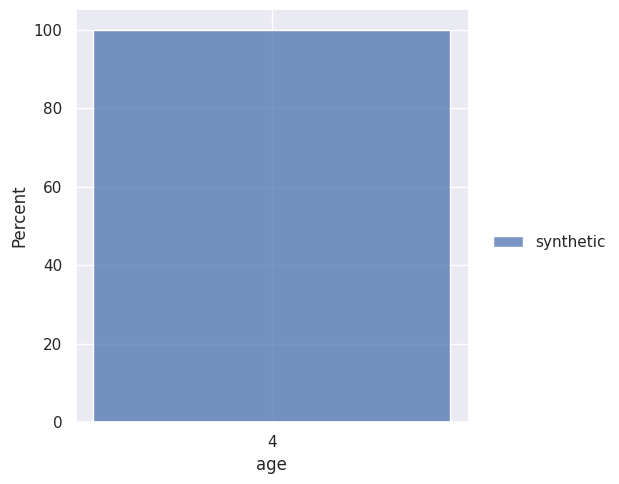

In [ ]:
# plot age
rl.vis.plot_bar(datasets=[syn], field="age")

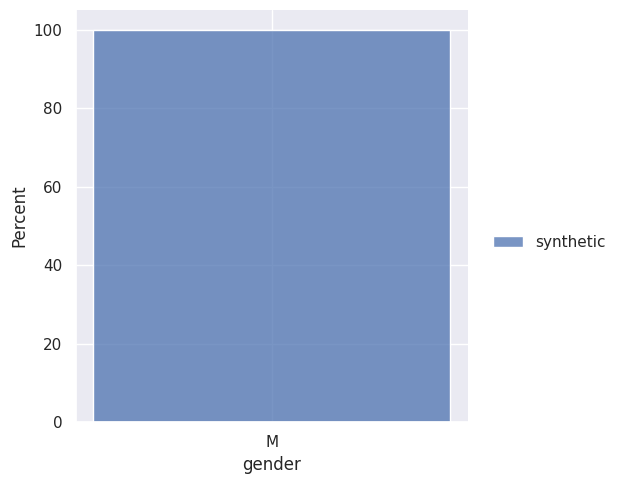

In [ ]:
# plot gender
rl.vis.plot_bar(datasets=[syn], field="gender")

#### Example 2: Multiple Conditions, Controlling Number of Sessions

**User Intent**

Generate the following synthetic dataset (using the same model):
1. 25 sessions with metadata (age = 4, gender = M)
2. 50 sessions with metadata either (age = 2, gender = F) or (age = 5, gender = M)

##### Specify these conditions in the generate config

In [ ]:
# given_metadata = [(age = 2, gender = F), (age = 5, gender = M)]
# expected output: 50 sessions with metadata that can be either
# (age = 2, gender = F) or (age = 5, gender = M).
given_metadata2 = {
    "age": ["2", "5"],
    "gender": ["F", "M"]
}
generate2_config = get_config(sessions=50, given_metadata=given_metadata2)
generate2 = ra.GenerateTimeGAN(generate2_config)

##### Run the generate workflow

In [ ]:
save = ra.DatasetSave(name="synthetic",
                      concat_tables=True,
                      concat_session_key="session_key")

# this shows how you can add two different generate actions to the same workflow
builder = rf.WorkflowBuilder()
builder.add(model)
builder.add(generate1, parents=[model])  # re-using generate action from example 1
builder.add(generate2, parents=[model])  # using generate action from example 2
builder.add(save, parents=[generate1, generate2])
workflow = await builder.start(conn)
print(f"Generate Workflow: {workflow.id()}")

Generate Workflow: 54fOuPdztZnCOpLpbYwwSB


In [ ]:
async for log in workflow.logs(level=rf.events.LogLevel.DEBUG):
    print(log)

In [ ]:
syn = None
async for sds in workflow.datasets():
  syn = await sds.to_local(conn)

In [ ]:
syn.to_pandas()

,timestamp,amount,age,gender,merchant,category,fraud,session_key
0,2023-01-20 21:02:00.116,5465.478728,2,F,M1788569036,fashion,0,25.0
1,2023-01-31 16:41:24.522,3315.243875,5,M,M1873032707,otherservices,0,26.0
2,2023-01-31 02:54:58.618,5547.200845,2,F,M17379832,sportsandtoys,1,27.0
3,2023-02-10 02:11:07.544,5545.306976,2,F,M1352454843,food,1,27.0
4,2023-02-03 14:18:19.630,3022.589916,5,M,M1198415165,health,1,28.0
...,...,...,...,...,...,...,...,...
429,2028-07-10 09:17:46.080,2782.486951,4,M,M1198415165,health,0,22.0
430,2028-07-15 01:41:35.913,3345.987021,4,M,M209847108,contents,0,22.0
431,2028-07-20 13:08:41.885,3371.404961,4,M,M1741626453,health,1,23.0
432,2028-07-29 21:42:38.234,3190.142629,4,M,M933210764,hotelservices,0,23.0


##### Validate metadata fields are constrained to given_metadata:

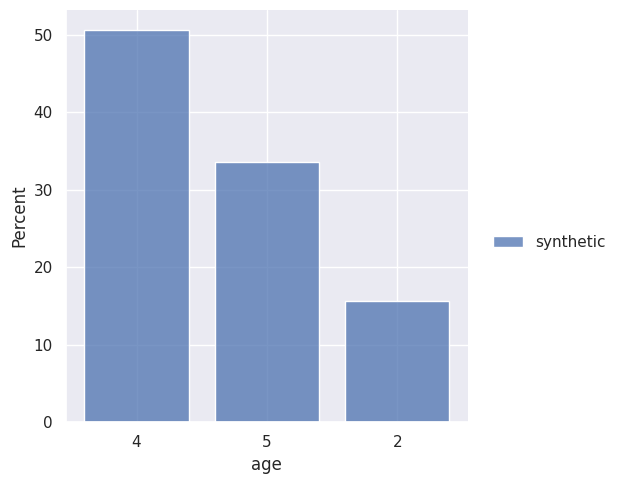

In [ ]:
# plot age
rl.vis.plot_bar(datasets=[syn], field="age")

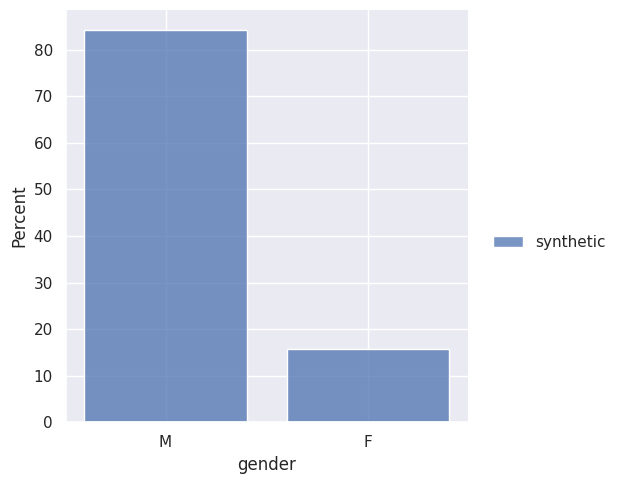

In [ ]:
# plot gender
rl.vis.plot_bar(datasets=[syn], field="gender")